## Детектирование сигнала светофора

Проект направлен на обнаружение сигнала светофора с использованием машинного обучения
Задачи:
- Обнаружение красного (круглого) сигнала в дневное время
- Обнаружение желтого (круглого) сигнала в дневное время
- Обнаружение зеленого (круглого) сигнала в дневное время
- Детектирование отсутствия светофора в дневное время

Для проекта используются следующие датасеты:
- тренировочный (4 датасета: red, yellow, green, empty - без светофора)
-  тестовый  (4 датасета: red, yellow, green, empty - без светофора)

Каждый датасет представляет собой набор изображений с трехсекционным светофором в дневное время (для набора empty - без светофора в дневное время).

In [59]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [60]:
!wget https://www.dropbox.com/s/o56f33f9zopni4z/train.zip?dl=0  -O train.zip

--2023-01-20 14:16:21--  https://www.dropbox.com/s/o56f33f9zopni4z/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/o56f33f9zopni4z/train.zip [following]
--2023-01-20 14:16:21--  https://www.dropbox.com/s/raw/o56f33f9zopni4z/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37bb182c8d95938b7488330fcb.dl.dropboxusercontent.com/cd/0/inline/B079S4H66tblEiY9nM0FpyoPVJV4WfOiYndmXHoaihzlq8DDS4WUQjvKc0o3rKlFXcfP955pMvZG_k2q0sjpQkN2vuUO2g1DNY5eq7nndKiQqCz3OHSApy4_QYM4rffB_DCwv9vXhdj2pn4czJiadhesKG2bGUYUojC34WTHb4JNKw/file# [following]
--2023-01-20 14:16:21--  https://uc37bb182c8d95938b7488330fcb.dl.dropboxusercontent.com/cd/0/inline/B079S4H66tblEiY9nM0FpyoPVJV4WfOiYndmXHoaihzlq8DDS4WUQjvKc0o3rKlFXcfP955pMvZG_k2q0sjp

In [61]:
!wget https://www.dropbox.com/s/45187nx5uvcddga/test.zip?dl=0 -O test.zip

--2023-01-20 14:16:41--  https://www.dropbox.com/s/45187nx5uvcddga/test.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/45187nx5uvcddga/test.zip [following]
--2023-01-20 14:16:41--  https://www.dropbox.com/s/raw/45187nx5uvcddga/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc84ab6677c8bdb20039674a2d69.dl.dropboxusercontent.com/cd/0/inline/B05NGzFho4ZU4nxPZ8CTFZM0VEf_tphiojD30A1blbSOXf0nc-qdLN82mmGLVEX4V3r-5KEnAKabhF0KX27MceJ1nWUGY3WaBdPBqEUm9c2GN9GsuDGFopEdWvptQYQwutRkB0v0cIpa4X-eDKGwJuM47tdnT_qBPH09Q45Ng8v2sA/file# [following]
--2023-01-20 14:16:42--  https://uc84ab6677c8bdb20039674a2d69.dl.dropboxusercontent.com/cd/0/inline/B05NGzFho4ZU4nxPZ8CTFZM0VEf_tphiojD30A1blbSOXf0nc-qdLN82mmGLVEX4V3r-5KEnAKabhF0KX27MceJ

In [62]:
!ls

sample_data  test  test.zip  train  train.zip


In [64]:
!unzip -q train.zip

In [65]:
!ls train

green  red  yellow


In [66]:
!unzip -q test.zip

In [67]:
!ls test

green  red  yellow


In [68]:
train_path='train'
test_path='test'

Смотрим примеры картинок

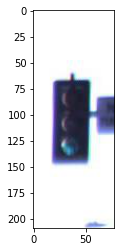

In [69]:
img_path = f'{train_path}/green/green_10.jpg'
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [70]:
train_dataset = image_dataset_from_directory(f'{train_path}',
                                             batch_size=128,
                                             image_size=(100, 50))

Found 823 files belonging to 3 classes.


In [71]:
class_names = train_dataset.class_names

In [72]:
class_names

['green', 'red', 'yellow']

Набор данных для тестирования

In [73]:
test_dataset = image_dataset_from_directory(f'{test_path}',
                                             batch_size=128,
                                             image_size=(100, 50))

Found 680 files belonging to 3 classes.


## Создаем составную нейронную сеть

In [74]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [75]:
inputs = layers.Input(shape=(100, 50, 3))
x = img_augmentation(inputs)
model = EfficientNetV2B0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
# outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
num_classes = 3 # Задаем количество классов
outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [76]:
one_hot_encoded_train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
one_hot_encoded_test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

Компилируем составную нейронную сеть

In [77]:
# Для задачи с двумя классами изображений
# model.compile(loss='binary_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

## Обучаем сеть

In [80]:
history = model.fit(one_hot_encoded_train_dataset,
                    epochs=18)

Epoch 1/18
7/7 [==============================] - 13s 2s/step - loss: 0.1733 - accuracy: 0.9429
Epoch 2/18
7/7 [==============================] - 12s 2s/step - loss: 0.1858 - accuracy: 0.9344
Epoch 3/18
7/7 [==============================] - 12s 2s/step - loss: 0.1768 - accuracy: 0.9368
Epoch 4/18
7/7 [==============================] - 13s 2s/step - loss: 0.1828 - accuracy: 0.9356
Epoch 5/18
7/7 [==============================] - 14s 2s/step - loss: 0.1770 - accuracy: 0.9332
Epoch 6/18
7/7 [==============================] - 13s 2s/step - loss: 0.1625 - accuracy: 0.9478
Epoch 7/18
7/7 [==============================] - 12s 2s/step - loss: 0.1618 - accuracy: 0.9429
Epoch 8/18
7/7 [==============================] - 12s 2s/step - loss: 0.1641 - accuracy: 0.9453
Epoch 9/18
7/7 [==============================] - 12s 2s/step - loss: 0.1736 - accuracy: 0.9356
Epoch 10/18
7/7 [==============================] - 14s 2s/step - loss: 0.1718 - accuracy: 0.9368
Epoch 11/18
7/7 [======================

Проверяем качество обучения на тестовом наборе данных


In [81]:
scores = model.evaluate(one_hot_encoded_test_dataset, verbose=1)

6/6 [==============================] - 2s 49ms/step - loss: 0.3823 - accuracy: 0.8838


In [82]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 88.3824


## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [83]:
class_names

['green', 'red', 'yellow']

Загружаем изображение из файла

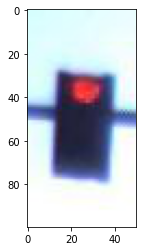

In [84]:
img_path = f'{test_path}/red/red_223.jpg'
img = image.load_img(img_path, target_size=(100, 50))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [85]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [86]:
prediction = model.predict(x)

1/1 [==============================] - 1s 1s/step


Печатаем результаты распознавания

In [87]:
prediction


array([[0.01283452, 0.9860139 , 0.00115154]], dtype=float32)